#### Introduction: Sentiment Analysis of Online Stores in Kenya

The rapid expansion of e-commerce in Kenya has seen platforms like Jumia, Kilimall, and Jiji dominate the online shopping landscape, offering consumers unprecedented convenience. As competition intensifies and customer expectations continue to rise, it becomes increasingly important for online platforms to not only attract customers but also retain their loyalty by delivering exceptional experiences. To remain competitive, these platforms must continuously refine their offerings based on user feedback. This project leverages **sentiment analysis** of customer reviews from popular Kenyan e-commerce sites to extract valuable insights into consumer perceptions. The primary goal is to inform the development of a new e-commerce app, "X," by identifying strengths, weaknesses, and opportunities for enhancement within the current market.

By analyzing patterns in sentiment, we aim to pinpoint the aspects of existing platforms that resonate most with users, as well as highlight common frustrations and areas in need of improvement. This research will compare the sentiment scores of various platforms to determine which has better customer reviews, thereby providing actionable insights for the new app's development team. The findings will enable "App X" to strategically adopt best practices from established competitors while avoiding pitfalls, ultimately helping developers create a user-centric platform optimized for the Kenyan market. These data-driven insights will empower the team to prioritize features that align with consumer preferences, fostering a competitive edge in the evolving e-commerce landscape.

###### Key Questions Our Analysis Aims to Answer:

1. Which online store (Jumia, Kilimall, or Jiji) has the highest positive sentiment from customers based on recent reviews?
2. What are the common pain points or negative experiences reported by users across these platforms?
3. Which features or aspects of online shopping do customers most frequently praise on each platform?
4. What actionable insights can be drawn to enhance the functionality and user experience of the new app "X" based on customer feedback from existing platforms? 

These questions will guide the analysis to ensure that the new app "X" is optimized for customer needs and stands out in the competitive online shopping market in Kenya.



In [1]:
!pip install google_play_scraper

In [2]:
!pip install emoji
!pip install wordcloud
!pip install TextBlob

## We can use libraries like NLTK, Gensim, TextBlob, spaCY, CoreNLP for data pre-processing and sentiment analysis. 
## We will use NLTK for pre-processing of data and TextBlob to calculate sentiment score (sentiment polarity and subjectivity ).

In [3]:
# importing important libraries
from google_play_scraper import Sort, reviews_all, reviews, app
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import string
import emoji
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk import word_tokenize, sent_tokenize


#### Jumia Reviews Web Scrapping, Data Importation and data description

##### 1.Jumia Web scrapping


In [4]:
#scrap Jumia reviews
Jumia, continuation_token = reviews(
    'com.jumia.android',
    sort = Sort.MOST_RELEVANT, # sort using at( date and time)
    count = 1000,
    filter_score_with = None
    )

##### 2. Jumia Data Import
Converting Jumia scrapped data to Data Frame(Structured data) for our analysis.

In [5]:
#Convert into a data frame

Jumia_rawdata = pd.DataFrame(np.array(Jumia), columns = ['review'])
Jumia_rawdata = Jumia_rawdata.join(pd.DataFrame(Jumia_rawdata.pop('review').tolist()))
Jumia_rawdata.head()
     

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c6ecd0fa-edb1-461a-b457-bd37fee531a4,All Shipper,https://play-lh.googleusercontent.com/a/ACg8oc...,The app improves and is consumer friendly. The...,4,961,16.6.1,2024-11-23 10:37:21,We are honored that you have chosen us and pla...,2024-11-26 13:46:58,16.6.1
1,531e70b7-a702-4de5-84e9-a18f27f05b9a,Brendah Akoth,https://play-lh.googleusercontent.com/a-/ALV-U...,Great app for shopping. I use it all the time ...,5,287,16.4.1,2024-12-24 01:44:20,What a wonderful review ! We’re having this hu...,2024-12-24 12:40:57,16.4.1
2,cc7f01e9-4695-4953-8d58-ef0f0eb7679f,Olawande Adebayo,https://play-lh.googleusercontent.com/a-/ALV-U...,It's an easy to use app with just one challeng...,4,17,7.6,2021-11-03 12:45:20,"Thank you , dear Adebayo ^^",2018-02-13 17:03:12,7.6
3,d367c2b9-f07f-4664-aaac-a514fc5c9548,PablAnu Coats,https://play-lh.googleusercontent.com/a-/ALV-U...,"Very helpful, can find a lot of items. But som...",4,205,14.14.0,2024-05-02 10:24:39,Thank you so much ! We're trying our best to m...,2024-05-03 13:38:52,14.14.0
4,9773a509-dd0d-4bc5-8ead-1d0aecc77eed,cece nene,https://play-lh.googleusercontent.com/a/ACg8oc...,The only good thing about this is that it's on...,1,3,5.11.1,2020-05-03 19:11:06,None,NaT,5.11.1


In [6]:
# renaming the at column
Jumia_data = pd.DataFrame(Jumia_rawdata)  # Creating a DataFrame
Jumia_data.rename(columns={'at': 'Review_timestamp'}, inplace=True)
Jumia_data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,Review_timestamp,replyContent,repliedAt,appVersion
0,c6ecd0fa-edb1-461a-b457-bd37fee531a4,All Shipper,https://play-lh.googleusercontent.com/a/ACg8oc...,The app improves and is consumer friendly. The...,4,961,16.6.1,2024-11-23 10:37:21,We are honored that you have chosen us and pla...,2024-11-26 13:46:58,16.6.1
1,531e70b7-a702-4de5-84e9-a18f27f05b9a,Brendah Akoth,https://play-lh.googleusercontent.com/a-/ALV-U...,Great app for shopping. I use it all the time ...,5,287,16.4.1,2024-12-24 01:44:20,What a wonderful review ! We’re having this hu...,2024-12-24 12:40:57,16.4.1
2,cc7f01e9-4695-4953-8d58-ef0f0eb7679f,Olawande Adebayo,https://play-lh.googleusercontent.com/a-/ALV-U...,It's an easy to use app with just one challeng...,4,17,7.6,2021-11-03 12:45:20,"Thank you , dear Adebayo ^^",2018-02-13 17:03:12,7.6
3,d367c2b9-f07f-4664-aaac-a514fc5c9548,PablAnu Coats,https://play-lh.googleusercontent.com/a-/ALV-U...,"Very helpful, can find a lot of items. But som...",4,205,14.14.0,2024-05-02 10:24:39,Thank you so much ! We're trying our best to m...,2024-05-03 13:38:52,14.14.0
4,9773a509-dd0d-4bc5-8ead-1d0aecc77eed,cece nene,https://play-lh.googleusercontent.com/a/ACg8oc...,The only good thing about this is that it's on...,1,3,5.11.1,2020-05-03 19:11:06,None,NaT,5.11.1


##### 3. Jumia Data Description

In [7]:
# Data Description 
print(Jumia_data.shape)
Jumia_data.info()

len(Jumia_data.index) # checking the number of observations for our dataset

(1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1000 non-null   object        
 1   userName              1000 non-null   object        
 2   userImage             1000 non-null   object        
 3   content               1000 non-null   object        
 4   score                 1000 non-null   int64         
 5   thumbsUpCount         1000 non-null   int64         
 6   reviewCreatedVersion  950 non-null    object        
 7   Review_timestamp      1000 non-null   datetime64[ns]
 8   replyContent          960 non-null    object        
 9   repliedAt             960 non-null    datetime64[ns]
 10  appVersion            950 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 86.1+ KB


1000

###### Some of the data is not nececessary for our analysis so we can extract only the columns that have useful information

In [8]:
# drop the unnecesarry columns before we can start the EDA(Exploratory Data Analysis)# drop the unnecesarry columns before we can start the EDA(Exploratory Data Analysis)
# Compare App versions 

Jumia_data1 = Jumia_data[["content","reviewCreatedVersion","score","Review_timestamp","thumbsUpCount"]]

# arranging the data starting from the newest to oldest

Jumia_pointsort_data = Jumia_data1.sort_values(by="Review_timestamp", ascending= False) 
Jumia_pointsort_data.head() 

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount
367,"At first you guys have been the best to me,but...",16.11.0,3,2025-02-06 21:15:04,0
99,love the jumia online market.. they're very tr...,16.10.0,5,2025-02-06 21:11:05,0
536,easier to use with a variety of choice items t...,16.9.0,4,2025-02-06 19:49:21,0
370,Makes online shopping hassle-free and I always...,16.11.0,5,2025-02-06 15:58:03,0
373,Very reliable and has great prices and product...,16.11.0,5,2025-02-06 11:52:25,0


##### Kilimall Reviews Web Scrapping, Data Importation and data description
##### 1.Kilimall Web scrapping

In [9]:
Kilimall, continuation_token = reviews(
    'net.kilimall.shop',
    sort = Sort.MOST_RELEVANT,
    count = 1000,
    filter_score_with = None  
)

##### 2. Kilimall Data Import
Converting Kilimall scrapped data to Data Frame(Structured data) for our analysis.

In [10]:
#Convert into a data frame

Kilimall_rawdata = pd.DataFrame(np.array(Kilimall), columns = ['review'])
Kilimall_rawdata = Kilimall_rawdata.join(pd.DataFrame(Kilimall_rawdata.pop('review').tolist()))
Kilimall_rawdata.head()
     

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,5596f1d2-b2d9-475b-b410-8fa43085e426,raphael wan. Mwaura,https://play-lh.googleusercontent.com/a/ACg8oc...,I've had the worst experience ever since the i...,1,1,5.8.0,2025-02-01 09:16:21,None,NaT,5.8.0
1,752e7bca-3e9e-4c2b-a604-dfbe7cade7ea,Adah Omedi,https://play-lh.googleusercontent.com/a-/ALV-U...,There's a time I was very unhappy with Kilimal...,5,2,5.8.0,2025-01-31 17:01:35,None,NaT,5.8.0
2,44884c9f-35ae-426a-9f9f-dd2c5fb17be7,Natasha Simiyu,https://play-lh.googleusercontent.com/a/ACg8oc...,Their systems overcharge. Had an order amounti...,1,43,5.6.2,2024-11-30 14:31:49,"Dear customer,we are sorry you didn't have a g...",2024-12-03 06:05:19,5.6.2
3,79d4ae17-635f-4cdd-808a-b2a9608b39da,Anthonio lewarz,https://play-lh.googleusercontent.com/a-/ALV-U...,"I have been using this app over five years, at...",1,0,5.7.0,2025-02-03 20:55:07,"Dear Customer,thank you for your support over ...",2025-02-06 12:06:09,5.7.0
4,14ecfe52-845b-43b6-8b18-5225cc72817a,Ogenga Moses,https://play-lh.googleusercontent.com/a-/ALV-U...,Lovely. If there is anything I love about Kili...,5,1,5.8.0,2025-02-01 22:24:10,"Dear Customer,thank you for your amazing revie...",2025-02-06 12:15:38,5.8.0


In [11]:
# renaming the at column
Kilimall_data = pd.DataFrame(Kilimall_rawdata)  # Creating a DataFrame
Kilimall_data.rename(columns={'at': 'Review_timestamp'}, inplace=True)
Kilimall_data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,Review_timestamp,replyContent,repliedAt,appVersion
0,5596f1d2-b2d9-475b-b410-8fa43085e426,raphael wan. Mwaura,https://play-lh.googleusercontent.com/a/ACg8oc...,I've had the worst experience ever since the i...,1,1,5.8.0,2025-02-01 09:16:21,None,NaT,5.8.0
1,752e7bca-3e9e-4c2b-a604-dfbe7cade7ea,Adah Omedi,https://play-lh.googleusercontent.com/a-/ALV-U...,There's a time I was very unhappy with Kilimal...,5,2,5.8.0,2025-01-31 17:01:35,None,NaT,5.8.0
2,44884c9f-35ae-426a-9f9f-dd2c5fb17be7,Natasha Simiyu,https://play-lh.googleusercontent.com/a/ACg8oc...,Their systems overcharge. Had an order amounti...,1,43,5.6.2,2024-11-30 14:31:49,"Dear customer,we are sorry you didn't have a g...",2024-12-03 06:05:19,5.6.2
3,79d4ae17-635f-4cdd-808a-b2a9608b39da,Anthonio lewarz,https://play-lh.googleusercontent.com/a-/ALV-U...,"I have been using this app over five years, at...",1,0,5.7.0,2025-02-03 20:55:07,"Dear Customer,thank you for your support over ...",2025-02-06 12:06:09,5.7.0
4,14ecfe52-845b-43b6-8b18-5225cc72817a,Ogenga Moses,https://play-lh.googleusercontent.com/a-/ALV-U...,Lovely. If there is anything I love about Kili...,5,1,5.8.0,2025-02-01 22:24:10,"Dear Customer,thank you for your amazing revie...",2025-02-06 12:15:38,5.8.0


##### 3. Kilimall Data Description

In [12]:
# Data Description 
print(Kilimall_data.shape)
Kilimall_data.info()

len(Kilimall_data.index) # checking the number of observations for our dataset

(1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1000 non-null   object        
 1   userName              1000 non-null   object        
 2   userImage             1000 non-null   object        
 3   content               1000 non-null   object        
 4   score                 1000 non-null   int64         
 5   thumbsUpCount         1000 non-null   int64         
 6   reviewCreatedVersion  934 non-null    object        
 7   Review_timestamp      1000 non-null   datetime64[ns]
 8   replyContent          872 non-null    object        
 9   repliedAt             872 non-null    datetime64[ns]
 10  appVersion            934 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 86.1+ KB


1000

In [13]:
# drop the unnecesarry columns before we can start the EDA(Exploratory Data Analysis)# drop the unnecesarry columns before we can start the EDA(Exploratory Data Analysis)

Kilimall_data1 = Kilimall_data[["content","reviewCreatedVersion","score","Review_timestamp","thumbsUpCount"]]

# arranging the data starting from the newest to oldest

Kilimall_pointsort_data = Kilimall_data1.sort_values(by="Review_timestamp", ascending= False) 
Kilimall_pointsort_data.head() 

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount
69,best online shop. I have ordered severally and...,5.8.0,5,2025-02-06 20:28:46,0
99,kilimall is the cheapest site when purchasing ...,5.8.0,5,2025-02-06 20:12:17,0
393,best for online shopping 😉,5.8.0,5,2025-02-06 18:15:25,0
218,fast delivery and the products are the best,5.8.0,5,2025-02-06 18:14:34,0
231,Really good app for online shopping,5.8.0,5,2025-02-06 15:17:02,0


##### Jiji Reviews Web Scrapping, Data Importation and data description
##### 1. Jiji Web scrapping

In [14]:
Jiji, continuation_token = reviews(
    'com.olx.ssa.ke',
    sort = Sort.MOST_RELEVANT,
    #count = 1000,
    filter_score_with = None   
)

##### 2. Jiji Data Import
Converting Jiji scrapped data to Data Frame(Structured data) for our analysis.

In [15]:
#Convert into a data frame

Jiji_rawdata = pd.DataFrame(np.array(Jiji), columns = ['review'])
Jiji_rawdata = Jiji_rawdata.join(pd.DataFrame(Jiji_rawdata.pop('review').tolist()))
Jiji_rawdata.head()
     

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,62bf0b3e-9424-4da0-a606-31de8145642d,djura 127,https://play-lh.googleusercontent.com/a/ACg8oc...,"Good day, There is something seriously wrong w...",1,9,4.10.3.2,2024-12-24 18:03:13,Thanks for your feedback! We are working const...,2025-01-08 16:48:31,4.10.3.2
1,afc1c1ab-38c9-433d-9a17-a33dd8634135,peter mbogoro,https://play-lh.googleusercontent.com/a-/ALV-U...,It's the best marketing for vehicles. Coz what...,5,12,4.10.3.2,2025-01-31 09:24:50,We’re grateful for your feedback! Your support...,2025-01-31 17:14:45,4.10.3.2
2,dc879a30-ffe6-43bc-841c-0cc9e4f0b6e4,Gordon Okeyo,https://play-lh.googleusercontent.com/a-/ALV-U...,"It's good, but needs rewriting on notification...",4,2,4.10.3.2,2025-01-09 20:00:46,Thank you so much for your feedback! We truly ...,2025-02-03 17:19:03,4.10.3.2
3,ec2df27d-009c-450f-968c-73c3f57ed14b,Chrispine Onyango,https://play-lh.googleusercontent.com/a-/ALV-U...,"The app is great, easy to use, and fast. Very ...",5,40,4.10.3.2,2025-01-22 18:11:25,Thank you so much for your feedback! We truly ...,2025-01-31 18:15:11,4.10.3.2
4,8348a321-c04a-4faa-a82a-e53b7dc6bbe0,Williams Wekesa,https://play-lh.googleusercontent.com/a-/ALV-U...,Great experience so far Introduce wallet where...,4,1,4.10.3.2,2025-01-10 10:51:26,Thank you for taking the time to provide us wi...,2025-02-03 17:18:40,4.10.3.2


In [16]:
# renaming the at column
Jiji_data = pd.DataFrame(Jiji_rawdata)  # Creating a DataFrame
Jiji_data.rename(columns={'at': 'Review_timestamp'}, inplace=True)
Jiji_data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,Review_timestamp,replyContent,repliedAt,appVersion
0,62bf0b3e-9424-4da0-a606-31de8145642d,djura 127,https://play-lh.googleusercontent.com/a/ACg8oc...,"Good day, There is something seriously wrong w...",1,9,4.10.3.2,2024-12-24 18:03:13,Thanks for your feedback! We are working const...,2025-01-08 16:48:31,4.10.3.2
1,afc1c1ab-38c9-433d-9a17-a33dd8634135,peter mbogoro,https://play-lh.googleusercontent.com/a-/ALV-U...,It's the best marketing for vehicles. Coz what...,5,12,4.10.3.2,2025-01-31 09:24:50,We’re grateful for your feedback! Your support...,2025-01-31 17:14:45,4.10.3.2
2,dc879a30-ffe6-43bc-841c-0cc9e4f0b6e4,Gordon Okeyo,https://play-lh.googleusercontent.com/a-/ALV-U...,"It's good, but needs rewriting on notification...",4,2,4.10.3.2,2025-01-09 20:00:46,Thank you so much for your feedback! We truly ...,2025-02-03 17:19:03,4.10.3.2
3,ec2df27d-009c-450f-968c-73c3f57ed14b,Chrispine Onyango,https://play-lh.googleusercontent.com/a-/ALV-U...,"The app is great, easy to use, and fast. Very ...",5,40,4.10.3.2,2025-01-22 18:11:25,Thank you so much for your feedback! We truly ...,2025-01-31 18:15:11,4.10.3.2
4,8348a321-c04a-4faa-a82a-e53b7dc6bbe0,Williams Wekesa,https://play-lh.googleusercontent.com/a-/ALV-U...,Great experience so far Introduce wallet where...,4,1,4.10.3.2,2025-01-10 10:51:26,Thank you for taking the time to provide us wi...,2025-02-03 17:18:40,4.10.3.2


##### 3. Jiji Data Description

In [17]:
# Data Description 
print(Jiji_data.shape)
Jiji_data.info()

len(Jiji_data.index) # checking the number of observations for our dataset

(100, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              100 non-null    object        
 1   userName              100 non-null    object        
 2   userImage             100 non-null    object        
 3   content               100 non-null    object        
 4   score                 100 non-null    int64         
 5   thumbsUpCount         100 non-null    int64         
 6   reviewCreatedVersion  95 non-null     object        
 7   Review_timestamp      100 non-null    datetime64[ns]
 8   replyContent          90 non-null     object        
 9   repliedAt             90 non-null     datetime64[ns]
 10  appVersion            95 non-null     object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 8.7+ KB


100

In [18]:
# drop the unnecesarry columns before we can start the EDA(Exploratory Data Analysis)# drop the unnecesarry columns before we can start the EDA(Exploratory Data Analysis)

Jiji_data1 = Jiji_data[["content","reviewCreatedVersion","score","Review_timestamp","thumbsUpCount"]]

# arranging the data starting from the newest to oldest

Jiji_pointsort_data = Jiji_data1.sort_values(by="Review_timestamp", ascending= False) 
Jiji_pointsort_data.head() 

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount
10,I have been a jiji seller for over 3 years but...,4.10.4.0,1,2025-02-04 16:02:25,0
22,"Best app doing good with jiji, transparent and...",4.10.4.0,5,2025-02-04 00:18:30,0
84,Easy to navigate and is trustworthy,4.10.4.0,5,2025-02-03 03:05:18,0
1,It's the best marketing for vehicles. Coz what...,4.10.3.2,5,2025-01-31 09:24:50,12
60,I joined jiji in 2017 and and first I didn't k...,4.10.2.3,5,2025-01-30 18:14:12,0


### EXPLORATORY DATA ANALYSIS
### 1. JUMIA - EXPLORATORY DATA ANALYSIS

##### CHECKING MISSING VALUES

In [19]:
Jumia_pointsort_data_sum_missing = Jumia_pointsort_data.isnull().sum()
print(Jumia_pointsort_data_sum_missing) 

content                  0
reviewCreatedVersion    50
score                    0
Review_timestamp         0
thumbsUpCount            0
dtype: int64


#### CHECKING THE REVIEWS IN TERMS OF SCORES TO SEE IF THERE IS MORE POSTIVE THAN THAN NEGATIVE FEEDBACK


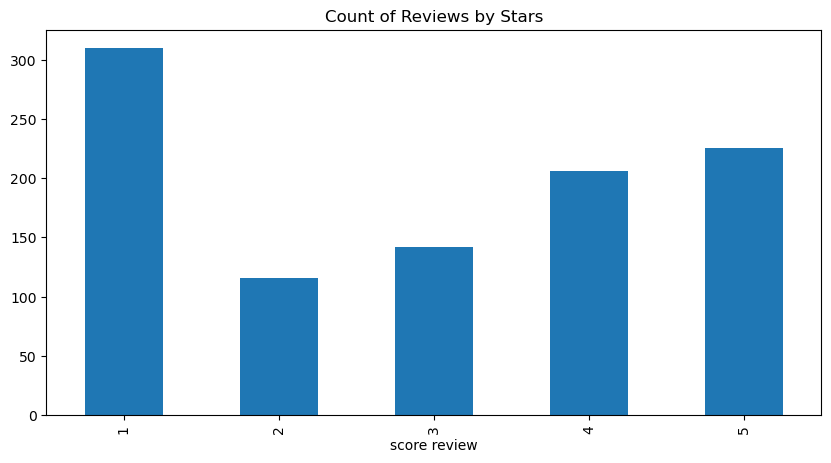

In [20]:
# Visualize data using a bar plot to determine if app is more positive reviews or negative reviews in terms of score

ax = Jumia_pointsort_data['score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('score review')
plt.show()

### KILIMALL - EXPLORATORY DATA ANALYSIS

##### CHECKING MISSING VALUES

In [21]:
Kilimall_pointsort_data_sum_missing = Kilimall_pointsort_data.isnull().sum()
print(Jumia_pointsort_data_sum_missing) 

content                  0
reviewCreatedVersion    50
score                    0
Review_timestamp         0
thumbsUpCount            0
dtype: int64


#### CHECKING THE REVIEWS IN TERMS OF SCORES TO SEE IF THERE IS MORE POSTIVE THAN THAN NEGATIVE FEEDBACK

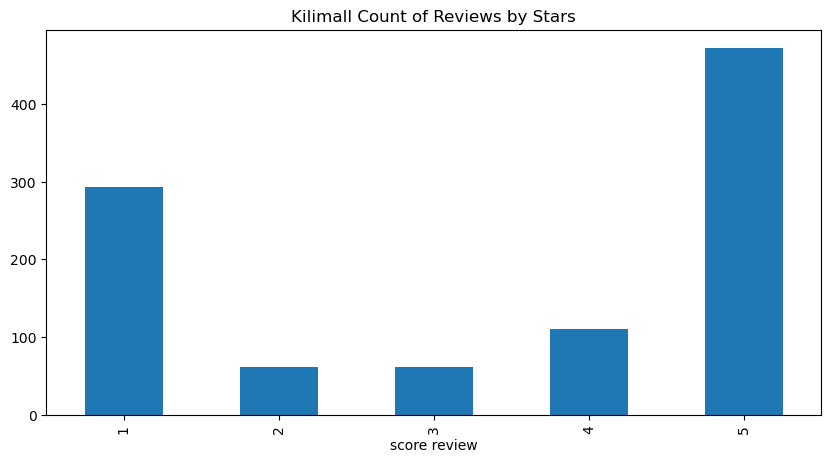

In [22]:
# Visualize data using a bar plot to determine if app is more positive reviews or negative reviews in terms of score

ax = Kilimall_pointsort_data['score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Kilimall Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('score review')
plt.show()

### JIJI - EXPLORATORY DATA ANALYSIS

##### CHECKING MISSING VALUES

In [23]:
Jiji_pointsort_data_sum_missing = Jiji_pointsort_data.isnull().sum()
print(Jiji_pointsort_data_sum_missing) 

content                 0
reviewCreatedVersion    5
score                   0
Review_timestamp        0
thumbsUpCount           0
dtype: int64


#### CHECKING THE REVIEWS IN TERMS OF SCORES TO SEE IF THERE IS MORE POSTIVE THAN THAN NEGATIVE FEEDBACK

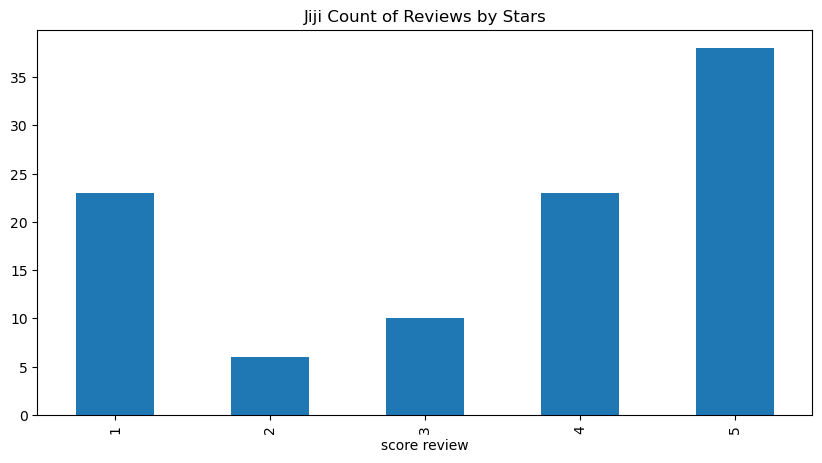

In [24]:
# Visualize data using a bar plot to determine if app is more positive reviews or negative reviews in terms of score

ax = Jiji_pointsort_data['score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Jiji Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('score review')
plt.show()

### JUMIA - DATA PREPROCESSING

###  Lowercasing - this is to maintain consistency of data

In [25]:
# check data type of content and change to str
type(Jumia_pointsort_data["content"])


pandas.core.series.Series

In [26]:
#convert to str
Jumia_pointsort_data['content'] = Jumia_pointsort_data['content'].astype(str)
print(Jumia_pointsort_data['content'].head(20))  


367    At first you guys have been the best to me,but...
99     love the jumia online market.. they're very tr...
536    easier to use with a variety of choice items t...
370    Makes online shopping hassle-free and I always...
373    Very reliable and has great prices and product...
739    Very good services especially door to door del...
360    jumia is the best app when it comes to shoppin...
26     Always mind about colors chosen by customers. ...
907    its been working not too much discount but it ...
348    Please I ordered for an item I'm yet to receiv...
346    Have been shopping with Jumia for years and it...
11     Jumia is a nice app. But there's a glitch 😕 I ...
835              always easy to use, safe, fast delivery
364    the tonner is very good and works well with th...
567    it's a good shopping app with a variety of pro...
873    If I can drop 0 star I think that will be the ...
205    It was very good but now it is one of the wors...
597    very optional just downl

In [27]:
#Lowercase all reviews

Jumia_pointsort_data['content'] = Jumia_pointsort_data['content'].apply(lambda x: x.lower())
print(Jumia_pointsort_data['content'].head()) 

# Most of the reviews are already in lowercase so can see the difference if we look at the whole dataset.


367    at first you guys have been the best to me,but...
99     love the jumia online market.. they're very tr...
536    easier to use with a variety of choice items t...
370    makes online shopping hassle-free and i always...
373    very reliable and has great prices and product...
Name: content, dtype: object


### Emojis

In [28]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(Jumia_pointsort_data.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
  expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
  #return expe.findall(s)
  return expe.sub(r'',s)


for i in Jumia_pointsort_data['content']:
  #print(str(extract_emojis(y)))
  extracted_emojis.append(str(extract_emojis(i)))

print(extracted_emojis[10])



True
have been shopping with jumia for years and it has been going smoothly and easily accessible i recommend 


### Stopwords

Removing stopwords can improve the performance to a great extent. Words such as myself, me , she, he , they , mine, you etc. When these words are removed only meaningful tokens are left.


In [29]:
# removing stop words
stop_words = stopwords.words('english')
Jumia_pointsort_data["extracted_emojis"] = extracted_emojis
Jumia_pointsort_data["extracted_emojis"] = Jumia_pointsort_data["extracted_emojis"].apply(lambda x:x if x not in stop_words else None)
print(Jumia_pointsort_data['extracted_emojis'].head())

367    at first you guys have been the best to me,but...
99     love the jumia online market.. they're very tr...
536    easier to use with a variety of choice items t...
370    makes online shopping hassle-free and i always...
373    very reliable and has great prices and product...
Name: extracted_emojis, dtype: object


### Stemming
Stemming is also an important process, it chops off the end of the word and transform the word into its root form. All suffixes like -s, -es, -ed, -ing are removed.


In [30]:
from nltk.stem.snowball import PorterStemmer
#stemming
def stemming(x):
  st = PorterStemmer()
  if x is not None:
    for word in x.split():
      st.stem(word)


Jumia_pointsort_data['extracted_emojis'].apply(lambda x: stemming(x))
print(Jumia_pointsort_data['extracted_emojis'].head())      
     

367    at first you guys have been the best to me,but...
99     love the jumia online market.. they're very tr...
536    easier to use with a variety of choice items t...
370    makes online shopping hassle-free and i always...
373    very reliable and has great prices and product...
Name: extracted_emojis, dtype: object


### JUMIA SENTIMENT ANALYSIS

In [31]:
#Use a model trained of a large corpus of data.
#Transformer model accounts for the words but also the context related to other words.

import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from scipy.special import softmax


In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


In [32]:
# Load RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming binary sentiment classification

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

C:\Users\HP\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:

# Ensure the model is in evaluation mode
model.eval()

# Function to calculate sentiment score
def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    return probabilities[0][2].item()  # Index 2 is for positive sentiment in this model

# Function to perform sensitivity analysis
def sensitivity_analysis(text):
    base_score = get_sentiment_score(text)
    words = text.split()
    sensitivity_scores = []

    for i, word in enumerate(words):
        modified_text = " ".join(words[:i] + words[i+1:])  # Remove one word at a time
        modified_score = get_sentiment_score(modified_text)
        sensitivity = base_score - modified_score
        sensitivity_scores.append((word, sensitivity))

    return sensitivity_scores


In [ ]:

# Apply sensitivity analysis to the 'reviews' column in the Jumia DataFrame
Jumia_pointsort_data["sensitivity_analysis"] = Jumia_pointsort_data["extracted_emojis"].apply(sensitivity_analysis)

# Display the results
print(Jumia_pointsort_data[["extracted_emojis", "sensitivity_analysis"]].head())

In [33]:
#Function to calculate sentiment score for whole data set

def senti_sc(x):
    if x is not None:
       return TextBlob(x).sentiment

Jumia_pointsort_data["Sentiment_score"]= Jumia_pointsort_data["extracted_emojis"].apply(senti_sc)
print(Jumia_pointsort_data.loc[0:19,['extracted_emojis','Sentiment_score']])



Empty DataFrame
Columns: [extracted_emojis, Sentiment_score]
Index: []


In [37]:
#for i in 
Jumia_pointsort_data['Sentiment_score'][0]

Sentiment(polarity=0.08459595959595961, subjectivity=0.5051346801346801)

In [38]:
from textblob.en import subjectivity
polarity=[]
subjectivity = []
for i in Jumia_pointsort_data['extracted_emojis'].values:
  try:
    analysis = TextBlob(i)
    polarity.append(analysis.sentiment.polarity)
    subjectivity.append(analysis.sentiment.subjectivity)
    
  except:
     polarity.append(0)
     subjectivity.append(0) 

In [39]:
Jumia_pointsort_data['polarity'] = polarity
Jumia_pointsort_data['subjectivity'] = subjectivity


##### What are some of the top most positive feedbacks?

In [40]:
conditions = [(Jumia_pointsort_data['polarity'] < 0),(Jumia_pointsort_data['polarity'] == 0),(Jumia_pointsort_data['polarity'] > 0)]
values = ['negative feedback', 'neutral feedback', 'positive feedback']
Jumia_pointsort_data['feedback'] = np.select(conditions,values)

Jumia_pointsort_data[Jumia_pointsort_data.polarity>0].head(10)

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount,extracted_emojis,Sentiment_score,polarity,subjectivity,feedback
15,i called customer care and the issue has been ...,16.10.0,3,2025-02-02 23:15:48,0,i called customer care and the issue has been ...,"(0.20625, 0.70625)",0.206250,0.706250,positive feedback
33,i tried cancelling one of the orders i made tw...,16.10.0,2,2025-02-01 21:48:41,0,i tried cancelling one of the orders i made tw...,"(0.196875, 0.59375)",0.196875,0.593750,positive feedback
82,i have used this app for over 5 years had alwa...,16.11.0,2,2025-01-31 20:33:18,0,i have used this app for over 5 years had alwa...,"(0.1969642857142857, 0.4775892857142857)",0.196964,0.477589,positive feedback
74,this app has really helped me to buy things wi...,16.10.0,4,2025-01-27 11:31:32,0,this app has really helped me to buy things wi...,"(0.2, 0.2)",0.200000,0.200000,positive feedback
10,a great and easy-to-navigate platform for onli...,16.10.0,5,2025-01-26 02:34:12,32,a great and easy-to-navigate platform for onli...,"(0.5, 0.6799999999999999)",0.500000,0.680000,positive feedback
73,i've been using this jumia app for more than t...,16.10.0,5,2025-01-25 19:12:12,0,i've been using this jumia app for more than t...,"(0.35, 0.3)",0.350000,0.300000,positive feedback
11,jumia is a very good app for shopping and has ...,16.10.0,5,2025-01-22 10:09:15,22,jumia is a very good app for shopping and has ...,"(0.2683333333333333, 0.7633333333333333)",0.268333,0.763333,positive feedback
24,very easy to order and pay and delivery is som...,16.10.0,5,2025-01-22 01:29:50,0,very easy to order and pay and delivery is som...,"(0.354375, 0.5802083333333333)",0.354375,0.580208,positive feedback
27,your are the best online shopping platforms be...,16.10.0,4,2025-01-22 01:19:27,4,your are the best online shopping platforms be...,"(0.2833333333333333, 0.4166666666666667)",0.283333,0.416667,positive feedback
26,i love this app so much having been using it f...,16.10.0,3,2025-01-18 00:26:06,0,i love this app so much having been using it f...,"(0.24, 0.485)",0.240000,0.485000,positive feedback



#### What are the main issues or complaints highlighted by customers in their negative feedback?

In [41]:
subject_matter = Jumia_pointsort_data[Jumia_pointsort_data.subjectivity>0.5]
negative_subject_matter = subject_matter[subject_matter.polarity < 0]
negative_subject_matter.head()

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount,extracted_emojis,Sentiment_score,polarity,subjectivity,feedback
90,"this app is just frustrating, i redownloaded t...",16.10.0,1,2025-01-31 08:42:14,4,"this app is just frustrating, i redownloaded t...","(-0.07500000000000001, 0.5916666666666667)",-0.075000,0.591667,negative feedback
13,jumia are useless.... i ordered for 3 items an...,16.10.0,1,2025-01-27 15:29:22,1,jumia are useless.... i ordered for 3 items an...,"(-0.2333333333333333, 0.6)",-0.233333,0.600000,negative feedback
12,this is the worst shopping app i have ever dow...,16.10.0,1,2025-01-23 20:14:55,1,this is the worst shopping app i have ever dow...,"(-0.05, 0.6266666666666667)",-0.050000,0.626667,negative feedback
8,jumia is the worst logistics company to use ri...,16.10.0,1,2025-01-22 20:48:17,3,jumia is the worst logistics company to use ri...,"(-0.4228571428571429, 0.6121428571428571)",-0.422857,0.612143,negative feedback
14,ltely the jumia app has become a total let dow...,16.10.0,1,2025-01-21 15:40:15,16,ltely the jumia app has become a total let dow...,"(-0.10405092592592592, 0.5814814814814815)",-0.104051,0.581481,negative feedback


positive feedback    0.52
negative feedback    0.42
neutral feedback     0.06
Name: feedback, dtype: float64


Text(0.5, 1.0, 'Jumia feedback rate')

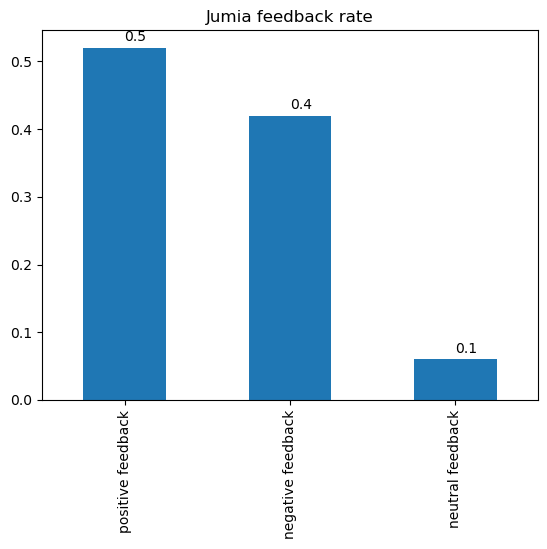

In [42]:
print(Jumia_pointsort_data['feedback'].value_counts(normalize=True))
Feedback_rate =  Jumia_pointsort_data['feedback'].value_counts(normalize=True).plot(kind="bar")
for i in Feedback_rate.patches:
  Feedback_rate.annotate('{:.1f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title('Jumia feedback rate')

positive feedback    52
negative feedback    42
neutral feedback      6
Name: feedback, dtype: int64


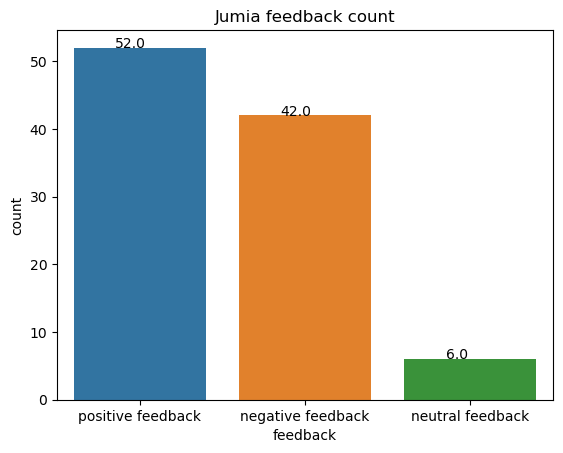

In [43]:
print(Jumia_pointsort_data['feedback'].value_counts())
Feedback_value = sns.countplot(x='feedback', data = Jumia_pointsort_data)
for i in Feedback_value.patches:
  Feedback_value.annotate('{:.1f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title('Jumia feedback count');

##### Notes On Jumia Analysis - to be completed
1. Which online store (Jumia, Kilimall, or Jiji) has the highest positive sentiment from customers based on recent reviews?
The app is fast and has easened the stress of physical shopping
2. What are the common pain points or negative experiences reported by users across these platforms?
3. Which features or aspects of online shopping do customers most frequently praise on each platform?
4. What actionable insights can be drawn to enhance the functionality and user experience of the new app "X" based on customer feedback from existing platforms? 

### KILIMALL - DATA PREPROCESSING
#### Lowercasing - this is to maintain consistency of data

In [44]:
# check data type of content and change to str
type(Kilimall_pointsort_data["content"])


pandas.core.series.Series

In [45]:
#convert to str
Kilimall_pointsort_data['content'] = Kilimall_pointsort_data['content'].astype(str)
print(Kilimall_pointsort_data['content'].head(20))  


553                               Simple and easy to use
31     Angelina constantly provides exceptionally ser...
3      I have been using this app over five years, at...
129    good online shop to consider fast and easy to ...
963     the best online business platform you can trust.
226    In my opinion,I think this is one of the legit...
22     Kilimall never fails it is my number one shopp...
15     nice shopping app with more quality varieties ...
164       the best and convenient online shopping centre
208         💯The best app to chop,, 🤞very fast no delays
4      Lovely. If there is anything I love about Kili...
934       The product was good so I got satisfied by it.
826                 It is awesome. I really like the app
195    Good quality products and delivered on and gre...
398                             very smart,as it appears
135    none like this. never had a beautiful experien...
767    Magret customer service helped me to get Item ...
242                    Nice in 

In [46]:
#Lowercase all reviews

Kilimall_pointsort_data['content'] = Kilimall_pointsort_data['content'].apply(lambda x: x.lower())
print(Kilimall_pointsort_data['content'].head()) 

# Most of the reviews are already in lowercase so can see the difference if we look at the whole dataset.


553                               simple and easy to use
31     angelina constantly provides exceptionally ser...
3      i have been using this app over five years, at...
129    good online shop to consider fast and easy to ...
963     the best online business platform you can trust.
Name: content, dtype: object


### Emojis

In [47]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(Kilimall_pointsort_data.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
  expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
  #return expe.findall(s)
  return expe.sub(r'',s)


for i in Kilimall_pointsort_data['content']:
  #print(str(extract_emojis(y)))
  extracted_emojis.append(str(extract_emojis(i)))

print(extracted_emojis[100])    

True
refurbished phones work the worst, laptops too i would advise for physical shopping for electronics


### Stopwords

In [48]:
# removing stop words
stop_words = stopwords.words('english')
Kilimall_pointsort_data["extracted_emojis"] = extracted_emojis
Kilimall_pointsort_data["extracted_emojis"] = Kilimall_pointsort_data["extracted_emojis"].apply(lambda x:x if x not in stop_words else None)
print(Kilimall_pointsort_data['extracted_emojis'].head())

553                               simple and easy to use
31     angelina constantly provides exceptionally ser...
3      i have been using this app over five years, at...
129    good online shop to consider fast and easy to ...
963     the best online business platform you can trust.
Name: extracted_emojis, dtype: object


### Stemming

In [49]:
from nltk.stem.snowball import PorterStemmer
#stemming
def stemming(x):
  st = PorterStemmer()
  if x is not None:
    for word in x.split():
      st.stem(word)


Kilimall_pointsort_data['extracted_emojis'].apply(lambda x: stemming(x))
print(Kilimall_pointsort_data['extracted_emojis'].head())      
     

553                               simple and easy to use
31     angelina constantly provides exceptionally ser...
3      i have been using this app over five years, at...
129    good online shop to consider fast and easy to ...
963     the best online business platform you can trust.
Name: extracted_emojis, dtype: object


### KILIMALL SENTIMENT ANALYSIS

In [50]:
#Function to calculate sentiment score for whole data set

def senti_sc(x):
    if x is not None:
       return TextBlob(x).sentiment

Kilimall_pointsort_data["Sentiment_score"]= Jumia_pointsort_data["extracted_emojis"].apply(senti_sc)
print(Kilimall_pointsort_data.loc[0:19,['extracted_emojis','Sentiment_score']])



                                      extracted_emojis  \
0    i've had the worst experience ever since the i...   
378  very beautiful product i will use it in my fie...   
232  i think that my product can get lost when i co...   
1    there's a time i was very unhappy with kilimal...   
50   i have never been disappointed by killmall. th...   
..                                                 ...   
165  i recommend anyone willing to purchase online ...   
35   ever since i started shopping from kilimall i ...   
487  the experience is great and the offers and the...   
172  i liked the delivery speed, and everything. ju...   
19   very navigable and efficient. no annoying ads ...   

                                 Sentiment_score  
0      (0.08459595959595961, 0.5051346801346801)  
378                                          NaN  
232                                          NaN  
1      (0.16845238095238096, 0.5166666666666666)  
50   (0.006666666666666668, 0.45666666666666667)

In [51]:
#for i in 
Kilimall_pointsort_data['Sentiment_score'][0]

Sentiment(polarity=0.08459595959595961, subjectivity=0.5051346801346801)

In [52]:
from textblob.en import subjectivity
polarity=[]
subjectivity = []
for i in Kilimall_pointsort_data['extracted_emojis'].values:
  try:
    analysis = TextBlob(i)
    polarity.append(analysis.sentiment.polarity)
    subjectivity.append(analysis.sentiment.subjectivity)
    
  except:
     polarity.append(0)
     subjectivity.append(0) 

In [53]:
Kilimall_pointsort_data['polarity'] = polarity
Kilimall_pointsort_data['subjectivity'] = subjectivity


In [57]:
conditions = [(Kilimall_pointsort_data['polarity'] < 0),(Kilimall_pointsort_data['polarity'] == 0),(Kilimall_pointsort_data['polarity'] > 0)]
values = ['negative feedback', 'neutral feedback', 'positive feedback']
Kilimall_pointsort_data['feedback'] = np.select(conditions,values)

Kilimall_pointsort_data[Kilimall_pointsort_data.polarity> 0].head(10)

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount,extracted_emojis,Sentiment_score,polarity,subjectivity,feedback
553,simple and easy to use,5.7.0,4,2025-02-03 21:18:45,0,simple and easy to use,NaN,0.216667,0.595238,positive feedback
31,angelina constantly provides exceptionally ser...,5.8.0,5,2025-02-03 21:12:19,0,angelina constantly provides exceptionally ser...,"(-0.04666666666666667, 0.7133333333333334)",0.322917,0.608333,positive feedback
3,"i have been using this app over five years, at...",5.7.0,1,2025-02-03 20:55:07,0,"i have been using this app over five years, at...","(0.025, 0.325)",0.106250,0.454167,positive feedback
129,good online shop to consider fast and easy to ...,5.7.0,5,2025-02-03 19:42:59,0,good online shop to consider fast and easy to ...,NaN,0.444444,0.677778,positive feedback
963,the best online business platform you can trust.,5.8.0,5,2025-02-03 17:29:46,0,the best online business platform you can trust.,NaN,1.000000,0.300000,positive feedback
22,kilimall never fails it is my number one shopp...,5.7.0,5,2025-02-03 12:24:10,0,kilimall never fails it is my number one shopp...,"(0.575, 0.45625)",0.312500,0.375000,positive feedback
15,nice shopping app with more quality varieties ...,5.8.0,5,2025-02-03 00:08:17,0,nice shopping app with more quality varieties ...,"(0.20625, 0.70625)",0.320000,0.400000,positive feedback
164,the best and convenient online shopping centre,5.8.0,5,2025-02-02 22:19:16,0,the best and convenient online shopping centre,NaN,1.000000,0.300000,positive feedback
208,"💯the best app to chop,, 🤞very fast no delays",5.7.0,5,2025-02-02 21:14:57,0,"the best app to chop,, very fast no delays",NaN,0.630000,0.540000,positive feedback
4,lovely. if there is anything i love about kili...,5.8.0,5,2025-02-01 22:24:10,1,lovely. if there is anything i love about kili...,"(0.4666666666666666, 0.5666666666666668)",0.358286,0.607429,positive feedback


#### What are the main issues or complaints highlighted by customers in their negative feedback?

In [61]:
subject_matter = Kilimall_pointsort_data[Kilimall_pointsort_data.subjectivity>0.5]
negative_subject_matter = subject_matter[subject_matter.polarity < 0]
negative_subject_matter.head()

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount,extracted_emojis,Sentiment_score,polarity,subjectivity,feedback
50,i have never been disappointed by killmall. th...,5.8.0,3,2025-01-31 13:17:29,0,i have never been disappointed by killmall. th...,"(0.006666666666666668, 0.45666666666666667)",-0.2500,0.625000,negative feedback
12,kilimall did you stop shipping products for th...,5.8.0,4,2025-01-31 01:18:48,1,kilimall did you stop shipping products for th...,"(-0.05, 0.6266666666666667)",-0.3125,0.583333,negative feedback
751,will never get tired of shopping at kilimall,5.8.0,5,2025-01-29 23:28:17,0,will never get tired of shopping at kilimall,NaN,-0.4000,0.700000,negative feedback
49,i encountered bad experience after returning a...,5.8.0,1,2025-01-29 12:48:33,0,i encountered bad experience after returning a...,"(0.27849025974025976, 0.4858225108225108)",-0.4725,0.686667,negative feedback
557,supplier deliver different items and even when...,5.7.0,1,2025-01-23 09:52:26,0,supplier deliver different items and even when...,NaN,-0.3500,0.633333,negative feedback


positive feedback    0.702
negative feedback    0.255
neutral feedback     0.043
Name: feedback, dtype: float64


Text(0.5, 1.0, 'Kilimall feedback rate')

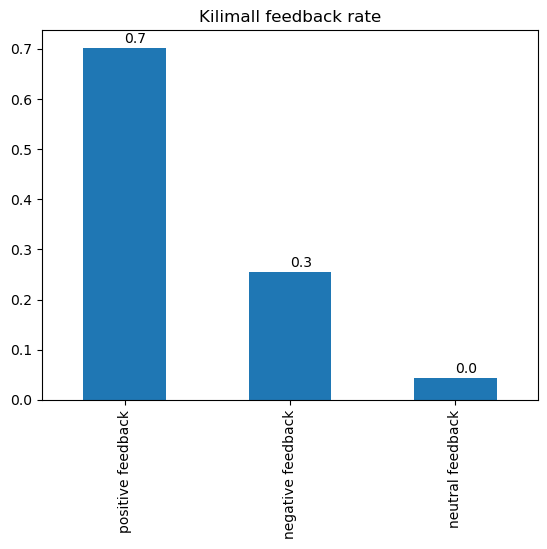

In [62]:
print(Kilimall_pointsort_data['feedback'].value_counts(normalize=True))
Feedback_rate =  Kilimall_pointsort_data['feedback'].value_counts(normalize=True).plot(kind="bar")
for i in Feedback_rate.patches:
  Feedback_rate.annotate('{:.1f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title('Kilimall feedback rate')

positive feedback    702
negative feedback    255
neutral feedback      43
Name: feedback, dtype: int64


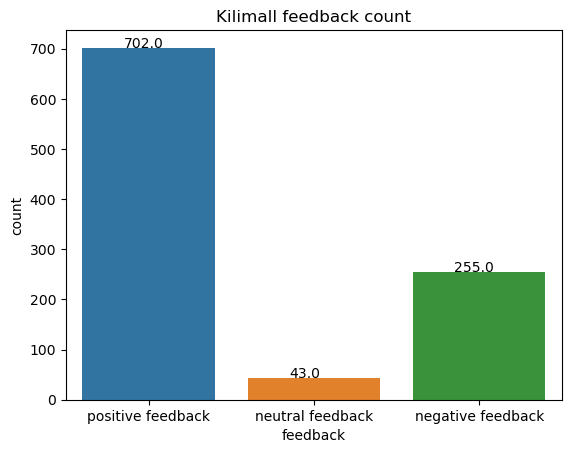

In [63]:
print(Kilimall_pointsort_data['feedback'].value_counts())
Feedback_value = sns.countplot(x='feedback', data = Kilimall_pointsort_data)
for i in Feedback_value.patches:
  Feedback_value.annotate('{:.1f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title('Kilimall feedback count');

##### Notes On Kilimall Analysis - to be completed
1. Which online store (Jumia, Kilimall, or Jiji) has the highest positive sentiment from customers based on recent reviews?
2. What are the common pain points or negative experiences reported by users across these platforms?
3. Which features or aspects of online shopping do customers most frequently praise on each platform?
4. What actionable insights can be drawn to enhance the functionality and user experience of the new app "X" based on customer feedback from existing platforms? 

### JIJI - DATA PREPROCESSING
### Lowercasing - this is to maintain consistency of data

In [64]:
# check data type of content and change to str
type(Jiji_pointsort_data["content"])


pandas.core.series.Series

In [65]:
#convert to str
Jiji_pointsort_data['content'] = Jiji_pointsort_data['content'].astype(str)
print(Jiji_pointsort_data['content'].head(20))  

82                  Easy to navigate and is trustworthy
1     It's the best marketing for vehicles. Coz what...
58    I joined jiji in 2017 and and first I didn't k...
10    The app is amazing....alot of opportunities av...
56      A perfect site for all your sales and purchases
20    Okay so I have nothing to say but it is true i...
19    Wonderful! Large selection, responsive vendors...
33    This app is very frustrating to the seller ,ho...
45    The more the updates the less the value of the...
11    Kenyan best advertising company ever.The staff...
3     The app is great, easy to use, and fast. Very ...
84       Great platform for buying and selling products
94    Excellent Work. The Best Marketing App in East...
36    A convenient platform to trade in both as a bu...
54                Simple , functional and user friendly
67    Gives range of almost everything you need to p...
32    Although i haven't finished preparing my new d...
37    Jiji app is best and easy to connect with 

In [66]:
#Lowercase all reviews

Jiji_pointsort_data['content'] = Jiji_pointsort_data['content'].apply(lambda x: x.lower())
print(Jiji_pointsort_data['content'].head()) 

# Most of the reviews are already in lowercase so can see the difference if we look at the whole dataset.


82                  easy to navigate and is trustworthy
1     it's the best marketing for vehicles. coz what...
58    i joined jiji in 2017 and and first i didn't k...
10    the app is amazing....alot of opportunities av...
56      a perfect site for all your sales and purchases
Name: content, dtype: object


### Emojis

In [67]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(Jiji_pointsort_data.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
  expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
  #return expe.findall(s)
  return expe.sub(r'',s)


for i in Jiji_pointsort_data['content']:
  #print(str(extract_emojis(y)))
  extracted_emojis.append(str(extract_emojis(i)))

print(extracted_emojis[100])    

True


IndexError: list index out of range

### Stopwords

In [68]:
# removing stop words
stop_words = stopwords.words('english')
Jiji_pointsort_data["extracted_emojis"] = extracted_emojis
Jiji_pointsort_data["extracted_emojis"] = Jiji_pointsort_data["extracted_emojis"].apply(lambda x:x if x not in stop_words else None)
print(Jiji_pointsort_data['extracted_emojis'].head())

82                  easy to navigate and is trustworthy
1     it's the best marketing for vehicles. coz what...
58    i joined jiji in 2017 and and first i didn't k...
10    the app is amazing....alot of opportunities av...
56      a perfect site for all your sales and purchases
Name: extracted_emojis, dtype: object


### Stemming

In [69]:
from nltk.stem.snowball import PorterStemmer
#stemming
def stemming(x):
  st = PorterStemmer()
  if x is not None:
    for word in x.split():
      st.stem(word)

Jiji_pointsort_data['extracted_emojis'].apply(lambda x: stemming(x))
print(Jiji_pointsort_data['extracted_emojis'].head())      
     

82                  easy to navigate and is trustworthy
1     it's the best marketing for vehicles. coz what...
58    i joined jiji in 2017 and and first i didn't k...
10    the app is amazing....alot of opportunities av...
56      a perfect site for all your sales and purchases
Name: extracted_emojis, dtype: object


### JIJI SENTIMENT ANALYSIS

In [70]:
#Function to calculate sentiment score for whole data set

def senti_sc(x):
    if x is not None:
       return TextBlob(x).sentiment
Jiji_pointsort_data["Sentiment_score"]= Jiji_pointsort_data["extracted_emojis"].apply(senti_sc)
print(Jiji_pointsort_data.loc[0:19,['extracted_emojis','Sentiment_score']])



Empty DataFrame
Columns: [extracted_emojis, Sentiment_score]
Index: []


In [71]:
#for i in 
Jiji_pointsort_data['Sentiment_score'][0]

Sentiment(polarity=-0.019444444444444448, subjectivity=0.4833333333333333)

In [72]:
from textblob.en import subjectivity
polarity=[]
subjectivity = []
for i in Jiji_pointsort_data['extracted_emojis'].values:
  try:
    analysis = TextBlob(i)
    polarity.append(analysis.sentiment.polarity)
    subjectivity.append(analysis.sentiment.subjectivity)
    
  except:
     polarity.append(0)
     subjectivity.append(0) 

In [73]:
Jiji_pointsort_data['polarity'] = polarity
Jiji_pointsort_data['subjectivity'] = subjectivity


In [74]:
conditions = [(Jiji_pointsort_data['polarity'] < 0),(Jiji_pointsort_data['polarity'] == 0),(Jiji_pointsort_data['polarity'] > 0)]
values = ['negative feedback', 'neutral feedback', 'positive feedback']
Jiji_pointsort_data['feedback'] = np.select(conditions,values)

Jiji_pointsort_data[Jumia_pointsort_data.polarity>0].head(10)

C:\Users\HP\AppData\Local\Temp\ipykernel_19668\4090279945.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Jiji_pointsort_data[Jumia_pointsort_data.polarity>0].head(10)


,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount,extracted_emojis,Sentiment_score,polarity,subjectivity,feedback
82,easy to navigate and is trustworthy,4.10.4.0,5,2025-02-03 03:05:18,0,easy to navigate and is trustworthy,"(0.43333333333333335, 0.8333333333333334)",0.433333,0.833333,positive feedback
1,it's the best marketing for vehicles. coz what...,4.10.3.2,5,2025-01-31 09:24:50,5,it's the best marketing for vehicles. coz what...,"(0.5333333333333333, 0.39444444444444443)",0.533333,0.394444,positive feedback
10,the app is amazing....alot of opportunities av...,4.10.4.0,5,2025-01-30 12:20:15,7,the app is amazing....alot of opportunities av...,"(0.3111111111111111, 0.4666666666666666)",0.311111,0.466667,positive feedback
56,a perfect site for all your sales and purchases,4.10.4.0,5,2025-01-27 09:36:38,0,a perfect site for all your sales and purchases,"(1.0, 1.0)",1.000000,1.000000,positive feedback
19,"wonderful! large selection, responsive vendors...",4.10.4.0,5,2025-01-25 12:06:02,1,"wonderful! large selection, responsive vendors...","(0.5714285714285714, 0.6761904761904761)",0.571429,0.676190,positive feedback
33,"this app is very frustrating to the seller ,ho...",4.10.3.2,1,2025-01-24 12:27:28,0,"this app is very frustrating to the seller ,ho...","(-0.010000000000000009, 0.75)",-0.010000,0.750000,negative feedback
45,the more the updates the less the value of the...,None,1,2025-01-24 11:10:26,1,the more the updates the less the value of the...,"(0.2777777777777778, 0.35555555555555557)",0.277778,0.355556,positive feedback
11,kenyan best advertising company ever.the staff...,4.10.3.2,5,2025-01-24 07:21:07,0,kenyan best advertising company ever.the staff...,"(0.6190885416666667, 0.44499999999999995)",0.619089,0.445000,positive feedback
3,"the app is great, easy to use, and fast. very ...",4.10.3.2,5,2025-01-22 18:11:25,35,"the app is great, easy to use, and fast. very ...","(0.49916666666666665, 0.7958333333333334)",0.499167,0.795833,positive feedback
84,great platform for buying and selling products,4.10.3.2,5,2025-01-21 15:14:42,0,great platform for buying and selling products,"(0.8, 0.75)",0.800000,0.750000,positive feedback


#### What are the main issues or complaints highlighted by customers in their negative feedback?

In [75]:
subject_matter = Jiji_pointsort_data[Jiji_pointsort_data.subjectivity>0.5]
negative_subject_matter = subject_matter[subject_matter.polarity < 0]
negative_subject_matter.head()

,content,reviewCreatedVersion,score,Review_timestamp,thumbsUpCount,extracted_emojis,Sentiment_score,polarity,subjectivity,feedback
33,"this app is very frustrating to the seller ,ho...",4.10.3.2,1,2025-01-24 12:27:28,0,"this app is very frustrating to the seller ,ho...","(-0.010000000000000009, 0.75)",-0.010000,0.750000,negative feedback
6,after few months of use ..🙌 i'm extremely disa...,4.10.2.3,1,2024-12-02 20:31:46,0,after few months of use .. i'm extremely disap...,"(-0.0015151515151515065, 0.5005050505050506)",-0.001515,0.500505,negative feedback
18,i have liked the app for the longest time beca...,4.10.1.0,2,2024-10-01 06:59:03,2,i have liked the app for the longest time beca...,"(-0.11999999999999997, 0.6433333333333333)",-0.120000,0.643333,negative feedback
13,there's a permanent 1 notification that keeps ...,4.10.0.0,1,2024-09-02 21:48:30,9,there's a permanent 1 notification that keeps ...,"(-0.18181818181818182, 0.5772727272727273)",-0.181818,0.577273,negative feedback
83,edit: 2022. you can only post a single ad on a...,4.8.2.1,3,2023-12-23 22:13:35,46,edit: 2022. you can only post a single ad on a...,"(-0.04353741496598639, 0.6130298273155416)",-0.043537,0.613030,negative feedback


positive feedback    0.75
negative feedback    0.22
neutral feedback     0.03
Name: feedback, dtype: float64


Text(0.5, 1.0, 'Jiji feedback rate')

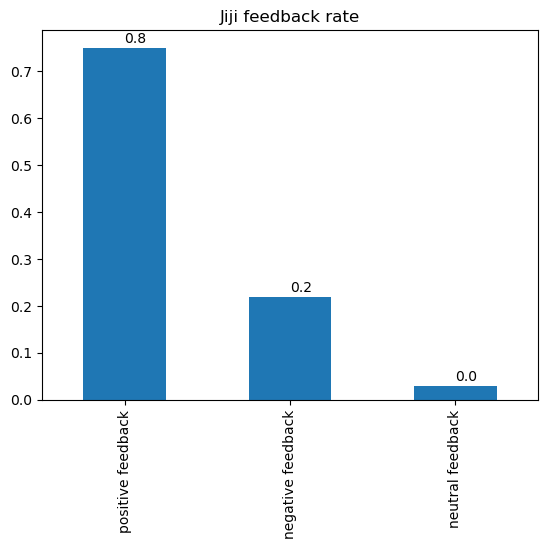

In [76]:
print(Jiji_pointsort_data['feedback'].value_counts(normalize=True))
Feedback_rate =  Jiji_pointsort_data['feedback'].value_counts(normalize=True).plot(kind="bar")
for i in Feedback_rate.patches:
  Feedback_rate.annotate('{:.1f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title('Jiji feedback rate')

positive feedback    75
negative feedback    22
neutral feedback      3
Name: feedback, dtype: int64


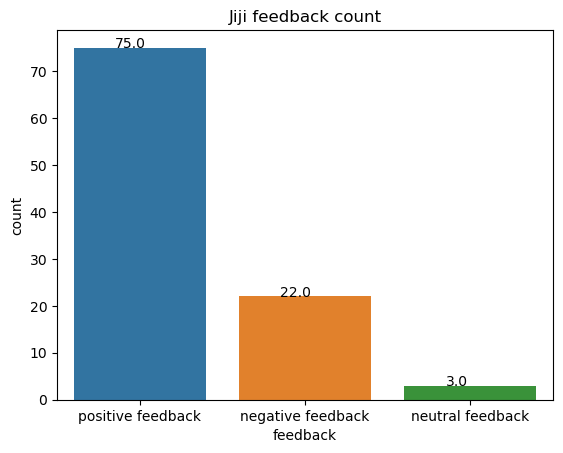

In [77]:
print(Jiji_pointsort_data['feedback'].value_counts())
Feedback_value = sns.countplot(x='feedback', data = Jiji_pointsort_data)
for i in Feedback_value.patches:
  Feedback_value.annotate('{:.1f}'.format(i.get_height()), (i.get_x()+0.25, i.get_height()+0.01))
plt.title('Jiji feedback count');

##### Notes On Jiji Analysis - to be completed
1. Which online store (Jumia, Kilimall, or Jiji) has the highest positive sentiment from customers based on recent reviews?
2. What are the common pain points or negative experiences reported by users across these platforms?
3. Which features or aspects of online shopping do customers most frequently praise on each platform?
4. What actionable insights can be drawn to enhance the functionality and user experience of the new app "X" based on customer feedback from existing platforms? 

#### Reccomendations on App X

##### Notes
*We removed the count of reviews so the code for checking mising data is giving 0 values. I couldn'nt figure out a way of making  the data start from a specific standard date for all the three stores.
*setting the sentiment score of Jumia returns an empty data set in th sentiment analysis
*The output data after sentiment analysis is kinda misleading some reviews are clealy negative but the analysis says they are positive and vice versa.

##### code we never used

Example: Assuming Jumia_pointsort_data contains 'reviewCreatedVersion' and frequency data

version_counts = Jumia_pointsort_data['reviewCreatedVersion'].value_counts()
                           
plt.bar(version_counts.index, version_counts.values)
plt.xlabel("Version Review")
plt.ylabel("Frequency")
plt.title("Jumia Score Review Bar Chart")
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
plt.tight_layout()       # Adjust layout for better fit
plt.show()Jumia.Jumia_pointsort_data['reviewCreatedVersion'.nunique(dropna=True)

In [ ]:

# Plot histograms for each app
plt.hist(Jumia_pointsort_data['score'], bins=5, alpha=0.7, label='Jumia', color='blue', edgecolor='black')
plt.hist(Kilimall_pointsort_data['score'], bins=5, alpha=0.7, label='Kilimall', color='green', edgecolor='black')
plt.hist(Jiji_pointsort_data['score'], bins=5, alpha=0.7, label='Jiji', color='red', edgecolor='black')

# Add labels, title, and legend
plt.xlabel('Score review')
plt.ylabel('Frequency')
plt.title('Comparison of App Reviews')
plt.legend(loc='upper right')

# Display the plot
plt.show()

In [ ]:
**** I thought a grouped bar chart would make more sense but I couldn't figure a way of improving this code.


# Create bar positions
score = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'] 
x = np.arange(len('score'))  # Correctly use the length of the ratings list
width = 0.25  # Width of each bar

# Plot grouped bars7 plt.bar(x - width, Jumia_pointsort_data, width, label='Jumia', color='blue')
plt.bar(x - width, Jumia_pointsort_data, width, label='Jumia', color='blue')
plt.bar(x, Kilimall_pointsort_data, width, label='Kilimall', color='green')
plt.bar(x + width, Jiji_pointsort_data, width, label='Jiji', color='red')

# Add labels, title, and legend
plt.xlabel('Score review')
plt.ylabel('Frequency')
plt.title('Comparison of App Reviews')
plt.xticks(x, score)  # Use the ratings list for x-axis labels
plt.legend()

# Display the chart
plt.show()
